In [1]:
%run ./setup_notebook.ipynb

In [2]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
from googleapiclient.errors import HttpError
import pickle
import utils.utils_funcs as uf
import run_functions as rf
from subsets_analysis import Subsets
import bisect

In [3]:
mice_dicts = [
    
{'mouse_id': 'J048', 'run_numbers': [27,28,29,30,32], 'runs': []},
{'mouse_id': 'RL048', 'run_numbers': [23, 24, 25, 28, 29], 'runs': []},
{'mouse_id': 'J063', 'run_numbers': [8,9,10,11,12,13,14], 'runs': []},
{'mouse_id': 'J064', 'run_numbers': [10,11,12,13,14,15], 'runs': []},
{'mouse_id': 'J065', 'run_numbers': [10,11,12,13,14,15], 'runs': []},
    
]

mice_dicts = [
            {'mouse_id': 'RL072', 'run_numbers': [19,20,21,24], 'runs': []},
       ] 

In [4]:
for mouse_dict in mice_dicts:
    for run_number in mouse_dict['run_numbers']:
        
        pkl_path = os.path.join(path_to_vape, 'run_pkls', mouse_dict['mouse_id'], 
                                'run{}.pkl'.format(run_number))

        with open(pkl_path, 'rb') as f:
            run = pickle.load(f)
            
        mouse_dict['runs'].append(run)
                

In [5]:
run = mice_dicts[0]['runs'][0]

In [6]:
run.__dict__.keys()

dict_keys(['mouse_id', 'df', 'rows_2p', 'rows_1p', 'dates_2p', 'paqs', 'naparm_folders', 'blimp_folders', 'pycontrol_folders', 'prereward_folders', 'tseries_folders', 'plane_numbers', 'reloaded', 'run_pycontrol_txt', 'num_planes', 'blimp_path', 'naparm_path', 'pycontrol_path', 'paq_path', 'prereward_path', 'tseries_paths', 'align_barcode', 'trial_info', 'session', 'print_lines', 'trial_time', 'outcome', 'slm_barcode', 'slm_trial_number', 'nogo_barcode', 'nogo_trial_number', 'alltrials_barcodes', 'rsync', 'trial_start', 'paq_rsync', 'frame_clock', 'x_galvo_uncaging', 'slm2packio', 'paq_rate', 'aligner', 'paq_correct', 'pre_rsync', 'pre_licks', 'pre_reward', 'prereward_aligner', 'both_aligner', 'num_frames', 's2p_path', 'spiral_start'])

In [7]:
def between_two_hits(idxs, easy_idxs, easy_outcome):
    
    assert len(easy_idxs) == len(easy_outcome)
    
    # Next easy trial from each test trial
    closest_after = np.array([bisect.bisect_left(easy_idxs, idx) for idx in idxs])
    # Previous easy trial from each test trial
    closest_before = closest_after - 1
    # Test trials before the first easy trial should have both previous and next
    # as the first easy trial
    closest_before[closest_before==-1] = 0
    # Test trials after the last easy trial should have both previous and next
    # as the last easy trial
    closest_after[idxs>easy_idxs[-1]] = len(easy_idxs)-1
    
    assert len(idxs) == len(closest_before) == len(closest_after)
    
    between_two = []
    for before, after in zip(closest_before, closest_after):
        if easy_outcome[before] and easy_outcome[after] == 'hit':
            between_two.append(True)
        else:
            between_two.append(False)
    
    assert len(between_two) == len(idxs)
    
    return between_two

In [8]:
def tanke_exclusion(run):
    
    trial_subsets = Subsets(run).trial_subsets
    assert len(trial_subsets) == len(run.outcome)
    
    easy_idxs = np.where(trial_subsets==150)[0]
    test_idxs = np.where((trial_subsets!=0) & (trial_subsets!=150))[0]
    nogo_idxs = np.where(trial_subsets==0)[0] 
    easy_outcomes = run.outcome[easy_idxs]
    
    global test_include
    test_include = between_two_hits(test_idxs, easy_idxs, easy_outcomes)
    nogo_include = between_two_hits(nogo_idxs, easy_idxs, easy_outcomes)
    
    return test_idxs[test_include], nogo_idxs[nogo_include]

In [9]:
test_idxs, nogo_idxs = tanke_exclusion(run)
hit_rate = (run.outcome[test_idxs] == 'hit').sum() / len(test_idxs)
fp_rate = (run.outcome[nogo_idxs] == 'fp').sum() / len(nogo_idxs)
test_dp = uf.d_prime(hit_rate, fp_rate)

test_dp

0.1215873827458573

In [21]:
def take_closest(arr, x):
    """
    Assumes arr is sorted. Returns closest value to x.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect.bisect_left(arr, x)
    if pos == 0:
        return arr[0]
    if pos == len(arr):
        return arr[-1]
    before = arr[pos - 1]
    after = arr[pos]
    if after - x < x - before:
        return after
    else:
        return before

In [11]:
def filler(arr):
    # Watch mutable type being mutated
    non_nans = np.where(~np.isnan(arr))[0]
    for idx, el in enumerate(arr): 
        if np.isnan(el):
            arr[idx] = arr[take_closest(non_nans, idx)]
    return arr

In [12]:
def running_bools(run, fill=False):
    subsets = Subsets(run)
    n_trials = len(run.outcome)

    easy_idx = np.where(subsets.trial_subsets == 150)[0]
    nogo_idx = np.where(subsets.trial_subsets == 0)[0]

    go_outcome = []
    nogo_outcome = []

    for trial in run.outcome[easy_idx]:
        if trial == 'hit':
            go_outcome.append(1)
        elif trial == 'miss':
            go_outcome.append(0)
        else:
            raise ValueError

    for trial in run.outcome[nogo_idx]:
        if trial == 'fp':
            nogo_outcome.append(1)
        elif trial == 'cr':
            nogo_outcome.append(0)
        else:
            raise ValueError

    go_bool = np.repeat(np.nan, n_trials)
    nogo_bool = np.repeat(np.nan, n_trials)

    go_bool[easy_idx] = go_outcome
    nogo_bool[nogo_idx] = nogo_outcome
    
    if not fill:
        return go_bool, nogo_bool
    else:
        return filler(go_bool), filler(nogo_bool)
    

In [13]:
def get_rolling_mean(arr, window_size):
    
    rolling_mean = []
    
    for i in range(len(arr)-window_size+1):
        
        rolling_mean.append(np.nanmean(arr[i:i+window_size]))
    
    return rolling_mean
    

In [14]:
def raster_trials(run, plot_test=False):

    marker_map = {
                'hit': 'red',
                'miss': 'blue',
                'cr': 'blue',
                'fp':'red'
                }

    trial_marker = [marker_map[i] for i in run.outcome]

    trial_subsets = Subsets(run).trial_subsets
    easy_idx = np.where(trial_subsets==150)[0]
    nogo_idx = np.where(trial_subsets==0)[0]
    test_idx = np.where((trial_subsets!=0) & (trial_subsets!=150))[0]
    n_trials = len(run.outcome)
    
    for trial in easy_idx:
        outcome = run.outcome[trial]
        plt.plot(trial, 1.3, marker='o', color=trial_marker[trial], markersize=8)

    for trial in nogo_idx:
        outcome = run.outcome[trial]
        plt.plot(trial, 0, marker='o', color=trial_marker[trial], markersize=8)
    
    if plot_test:
        labelled1 = True
        labelled2 = True
        for i, trial in enumerate(test_idx):
            include = test_include[i]
            if include:
                if labelled1:
                    labelled1 = False
                    plt.plot(trial, 0.5, marker='o', color='black', markersize=8, label='Included')
                else:
                    plt.plot(trial, 0.5, marker='o', color='black', markersize=8)
            else:
                if labelled2:
                    labelled2 = False
                    plt.plot(trial, 0.5, marker='o', color='green', markersize=8, label='Exluded')
                else:
                    plt.plot(trial, 0.5, marker='o', color='green', markersize=8)

    plt.annotate('150 Cell Stim Trial', [n_trials+5, 1.3], fontsize=15)
    plt.annotate('Test Trials', [n_trials+5, 0.5], fontsize=15)
    plt.annotate('NoGo Trial', [n_trials+5, -0.03], fontsize=15)

In [15]:
ws = 5
fill = False

go_bool, nogo_bool = running_bools(run, fill=fill)
running_go = get_rolling_mean(go_bool, ws)
running_nogo = get_rolling_mean(nogo_bool, ws)

running_dp = [utils.d_prime(go, nogo)
              for go, nogo in zip(running_go, running_nogo)]

running_dp = np.array(running_dp)

Text(0.5, 1.0, 'Window size 5\nArray filled with NaNs')

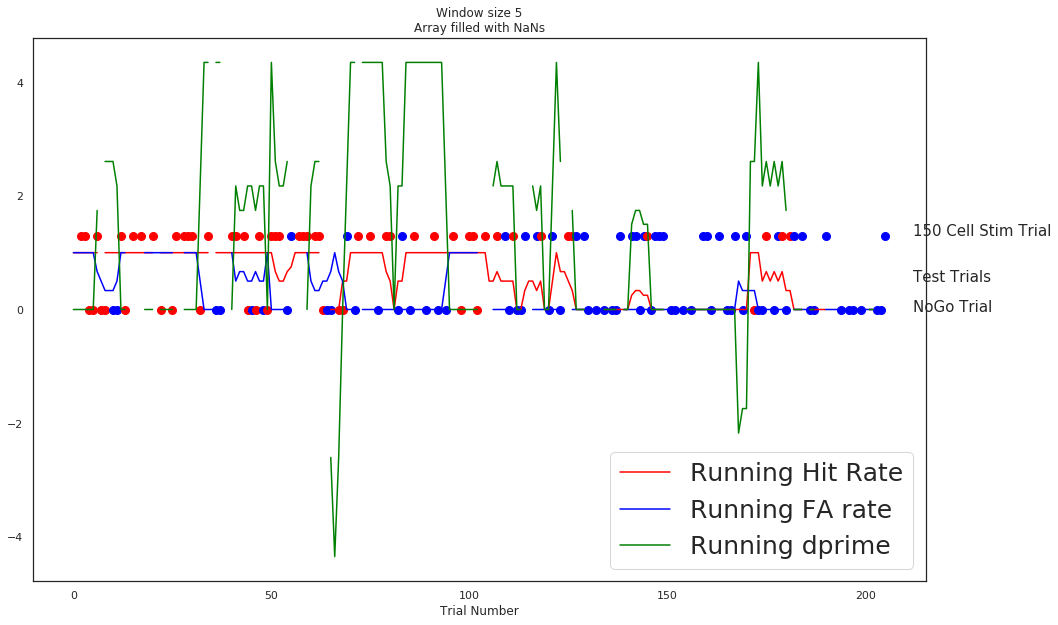

In [16]:
plt.figure(figsize=(16,10))
raster_trials(run)
plt.plot(running_go, color='red', label='Running Hit Rate')
plt.plot(running_nogo, color='blue', label='Running FA rate')
plt.plot(running_dp, color= 'green', label='Running dprime')
plt.xlabel('Trial Number')

plt.legend(fontsize=25)

if fill:
    fill_str = 'Array filled with closest boolean'
else:
    fill_str = 'Array filled with NaNs'

plt.title('Window size {}\n{}'.format(ws, fill_str))

In [17]:
rf.dprime_tanke(run)

0.4149686021930991

In [18]:
test_idxs, nogo_idxs = tanke_exclusion(run)
hit_rate = (run.outcome[test_idxs] == 'hit').sum() / len(test_idxs)
fp_rate = (run.outcome[nogo_idxs] == 'fp').sum() / len(nogo_idxs)
test_dp = uf.d_prime(hit_rate, fp_rate)

test_dp

0.1215873827458573

Text(0.5, 0, 'Trial Number')

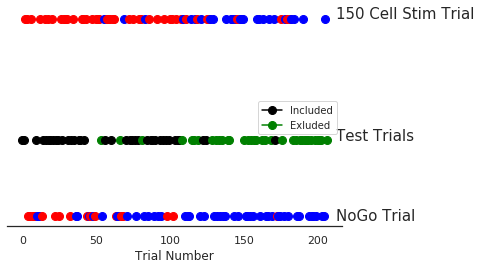

In [19]:
raster_trials(run, plot_test=True)
plt.legend(fontsize=10)
sns.despine(left=True)
plt.yticks([])
plt.xlabel('Trial Number')

array([ 30,  50, 150, 150,   0,   0, 150,   0,   0,  20,   0,   0, 150,
         0,   5, 150,  10, 150,  40,  50, 150,  20,   0,  10,   5,   0,
       150,   5, 150, 150, 150,  20,   0,  50, 150,  50,   0,   0,   5,
        10, 150, 150,  50, 150,   0,   0,   0, 150,   0,   0, 150, 150,
       150,  40,   0, 150,  20, 150, 150, 150,  20, 150, 150,   0,   0,
         0,  50,   0,   0, 150,  50,   0, 150,  10,  50, 150,   5,   0,
         5, 150, 150,  50,   0, 150,  20,   0, 150,  20,  20,   0,  20,
       150,   0,  30,   0,  20, 150,  30,   0,  40, 150, 150,   0,  20,
       150,  50,  40, 150,  40, 150,   0, 150,   0,   0, 150,  20,  20,
       150, 150,   5,   0, 150,  30,   0,  50, 150, 150, 150,  40, 150,
         0,  10,   0,  40,   0,  40,   0,   0, 150,  50,  50, 150, 150,
         0, 150, 150,   0, 150, 150, 150,  50,   0,   0,  50,   0,   5,
         0,  20,  10, 150, 150,   0,  40, 150,  40,   0,   0, 150,   5,
         0, 150,  50,   0,   0,   0, 150,  10,   0, 150, 150,   